In [8]:
# standard library
from pathlib import Path

# common libraries
import numpy as np
import xarray as xr 

# less common libraries
import esmlab  # convenience, but not necessary [https://esmlab.readthedocs.io/en/latest/]
import xesmf as xe  # regridding, see note below [https://xesmf.readthedocs.io/en/latest/]

# plotting -- not needed for the data processing step
import matplotlib as mpl
import matplotlib.pyplot as plt

import os

# Local functions

The function `isccp_makehist` cosntructs the old ISCCP histogram from the ISCCP H data files. It's a little more hard-coded than I'd usually like, but as long as they don't change the data structure, I guess it should work. 

It might be inefficient to do unstacking, but I don't remember this being slow, and we shouldn't have to do it often, so should be okay.


The `do_regrid` function uses xesmf, but only does simple bilinear interpolation. If you can't get xesmf to work (it can be finnicky because it relies on ESMpy and on the ESMF library, which are a bit touchy), I think the same interpolation can probably be done with recent versions of xarray (lat-lon to lat-lon, bilinear). **Oh,** and it appears that this isn't used here; it's there for comparison to CAM, but that part isn't in this notebook. So you could just delete that import and the function completely.


The `get_yyyymm` function just constructs strings for dates. These are later used for file names.

In [2]:
def isccp_makehist(isccp_data):
    """Convert ISCCP Series-H data from 1-d cloud types dimension to 2-d histogram."""
    # expects <xarray.DataArray 'cldamt_types' (time: ntime, cloud_type: 18, lat: 180, lon: 360)>
    # first combine liquid and ice:
    liq = isccp_data[:,[0,1,2,6,7,8,12,13,14],:,:]
    ice = isccp_data[:,[3,4,5,9,10,11,15,16,17],:,:]
    c_li = liq+ice
    # these are the tau and pc (cloud-top pressure) coords for c_li
    tau_ctr = [np.mean([0,3.55]), np.mean([3.55,22.63]), np.mean([22.63,450]),
          np.mean([0,3.55]), np.mean([3.55,22.63]), np.mean([22.63,450]),
          np.mean([0,3.55]), np.mean([3.55,22.63]), np.mean([22.63,450])]
    pc_ctr = [np.mean([680,1025]), np.mean([680,1025]), np.mean([680,1025]),
         np.mean([440,680]), np.mean([440,680]), np.mean([440,680]),
         np.mean([10,440]), np.mean([10,440]), np.mean([10,440])]
    # insert coordinates
    c_li['tau'] = ('cloud_type', tau_ctr)
    c_li['pc'] = ('cloud_type', pc_ctr)
    # make cloud_type a MultiIndex
    c_li2 = c_li.set_index(cloud_type=['tau','pc']) 
#     list(zip(c_li2.shape, c_li2.dims))
#     result: [(1, 'time'), (9, 'cloud_type'), (180, 'lat'), (360, 'lon')]
#   Now we return the unstacked version which would be: <xarray.DataArray 'cldamt_types' (time: ntime, lat: 180, lon: 360, tau: 3, pc: 3)>
#   And we transpose it to the correct order
    return c_li2.unstack('cloud_type').transpose("time", "tau", "pc", "lat", "lon")

In [3]:
def do_regrid(x, ogrid):
    igrid = xr.Dataset({'lat': (['lat'], x['lat']), 'lon': (['lon'], x['lon'])})
    regridder = xe.Regridder(igrid, ogrid, 'bilinear', periodic=True, filename="/Users/brianpm/Desktop/throwaway.nc")
    return regridder(x)

In [4]:
def get_yyyymm(t, with_hyphen=False):
    if with_hyphen:
        return "-".join([str(t.dt.year.values.item()), f"{t.dt.month.values.item():02d}"])
    else:
        return "".join([str(t.dt.year.values.item()), f"{t.dt.month.values.item():02d}"])

# Process data
Load the downloaded files int a dataset, use function `isccp_makehist` and then do the sums to make the cloud amounts. 

In [6]:
pwd

'/glade/u/home/jonahshaw/Scripts/git_repos/CESM2_analysis'

In [12]:
# os.listdir('/glade/u/home/jonahshaw/w/obs/ISCCPH')

In [14]:
raw_ISCCP_dir = '/glade/u/home/jonahshaw/w/obs/ISCCPH/'

In [27]:
out_dir = '/glade/u/home/jonahshaw/w/obs/ISCCP/'

In [15]:
# Observations
# isccp_obs = xr.open_mfdataset("/Volumes/Glyph6TB/ISCCP/ISCCP-Basic.HGM.v01r00.GLOBAL.*.nc", combine='by_coords')
isccp_obs = xr.open_mfdataset("%s/ISCCP-Basic.HGM.v01r00.GLOBAL.*.nc" % (raw_ISCCP_dir), combine='by_coords')

In [18]:
obs_clisccp = isccp_makehist(isccp_obs['cldamt_types'])

In [19]:
obs_clisccp.pc

<xarray.DataArray 'pc' (pc: 3)>
array([225. , 560. , 852.5])
Coordinates:
  * pc       (pc) float64 225.0 560.0 852.5

In [20]:
# derive cltisccp
# in order to keep missing data as missing rather than zero, we have to do one dim at a time with a min_count kwarg: <-- interesting
cltisccp = obs_clisccp.sum(dim='tau', min_count=1).sum(dim='pc', min_count=1).compute() # <-- here brian isn't excluding a -1 bin. Maybe not in obs?


In [32]:
cltisccp.sel(time=slice())

<xarray.DataArray 'cltisccp' (time: 402, lat: 180, lon: 360)>
array([[[      nan,       nan,       nan, ...,       nan,       nan,
               nan],
        [      nan,       nan,       nan, ...,       nan,       nan,
               nan],
        [      nan,       nan,       nan, ...,       nan,       nan,
               nan],
        ...,
        [55.399994, 55.399994, 55.399994, ..., 59.599995, 59.599995,
         59.599995],
        [61.89999 , 61.89999 , 61.89999 , ..., 60.49999 , 60.49999 ,
         60.49999 ],
        [65.59999 , 65.59999 , 65.59999 , ..., 59.8     , 59.8     ,
         59.8     ]],

       [[      nan,       nan,       nan, ...,       nan,       nan,
               nan],
        [      nan,       nan,       nan, ...,       nan,       nan,
               nan],
        [      nan,       nan,       nan, ...,       nan,       nan,
               nan],
...
        [      nan,       nan,       nan, ...,       nan,       nan,
               nan],
        [      nan,       nan,       nan, ...,       nan,       nan,
               nan],
        [      nan,       nan,       nan, ...,       nan,       nan,
               nan]],

       [[11.699997, 11.699997, 11.699997, ..., 12.599995, 12.599995,
         12.599995],
        [15.999996, 15.999996, 15.999996, ..., 19.599995, 19.599995,
         19.599995],
        [16.399994, 16.399994, 16.399994, ..., 19.899994, 19.899994,
         19.899994],
        ...,
        [      nan,       nan,       nan, ...,       nan,       nan,
               nan],
        [      nan,       nan,       nan, ...,       nan,       nan,
               nan],
        [      nan,       nan,       nan, ...,       nan,       nan,
               nan]]], dtype=float32)
Coordinates:
  * lon      (lon) float32 0.5 1.5 2.5 3.5 4.5 ... 355.5 356.5 357.5 358.5 359.5
  * lat      (lat) float32 -89.5 -88.5 -87.5 -86.5 -85.5 ... 86.5 87.5 88.5 89.5
  * time     (time) datetime64[ns] 1983-07-15 1983-08-15 ... 2016-12-15
Attributes:
    long_name:     Mean total cloud amount for all cloud types (sum liq, ice,...
    units:         percent
    valid_min:     -500
    valid_max:     500
    description:   Cloud detected by either IR or VIS threshold, type determi...
    cell_methods:  area: mean time: mean within days time: mean over days

### These histograms are only 3x3 so the cloud level is just a single pc index.

In [21]:
cllisccp = obs_clisccp.sel(pc=852.5).squeeze().sum(dim='tau', min_count=1).compute()

In [22]:
clmisccp = obs_clisccp.sel(pc=560.0).squeeze().sum(dim='tau', min_count=1).compute()
clhisccp = obs_clisccp.sel(pc=225.0).squeeze().sum(dim='tau', min_count=1).compute()

In [55]:
cltisccp_mo = cltisccp.sel(time=slice('1998-07-01',None))
cllisccp_mo = cllisccp.sel(time=slice('1998-07-01',None))
clmisccp_mo = clmisccp.sel(time=slice('1998-07-01',None))
clhisccp_mo = clhisccp.sel(time=slice('1998-07-01',None))

In [24]:

time_range_string = get_yyyymm(cltisccp['time'][0])+"-"+get_yyyymm(cltisccp['time'][-1])
time_range_string

'198307-201612'

In [58]:

time_range_string2 = get_yyyymm(cltisccp_mo['time'][0])+"-"+get_yyyymm(cltisccp_mo['time'][-1])
time_range_string2

'199807-201612'

In [25]:
'lat' in clhisccp.coords

True

# Write Files

The next few cells show how I saved the files for the 2D cloud amounts.

Looks like I worked it out for clt first, and then made a function to do the others.

In [79]:
# we should save cll, clm, clh, and clt so we don't have to always go through the whole dataset (and to always remember to be careful about summing nans)
# cltisccp.name = 'cltisccp'
# cltisccp.attrs['long_name'] = "Mean cloud amount for all cloud types (sum liq, ice, cloud-top pressure, and optical thickness)"
# cltisccp.attrs.pop('standard_name')
encoding = {'lat': {'zlib': False, '_FillValue': False},
            'lon': {'zlib': False, '_FillValue': False},
            'cltisccp': {'_FillValue': -999.0,'complevel': 4,'zlib': True}
            }
time_range_string = get_yyyymm(cltisccp['time'][0])+"-"+get_yyyymm(cltisccp['time'][-1])
# for output: variable_frequency_product-info_time-range.nc
output_name = "".join(["/Volumes/Glyph6TB/ISCCP/","_".join(["cltisccp", "mon", "HGM.v01r00", time_range_string]),".nc"])
print(output_name)
if Path(output_name).is_file():
    print("Already saved the file... not saving again.")
else:
    cltisccp.to_netcdf(output_name, encoding=encoding)

/Volumes/Glyph6TB/ISCCP/cltisccp_mon_HGM.v01r00_198307-201612.nc


In [26]:
def save_file(variable, new_name, out_dir=None, **kwargs):
    assert 'lat' in variable.coords
    assert 'lon' in variable.coords
    assert 'time' in variable.coords
    variable.name = new_name
    for k in kwargs:
        variable.attrs[k] = kwargs[k]
    if "standard_name" in variable.attrs:
        variable.attrs.pop('standard_name')
    encoding = {'lat': {'zlib': False, '_FillValue': False},
                'lon': {'zlib': False, '_FillValue': False},
                new_name: {'_FillValue': -999.0,'complevel': 4,'zlib': True}
                }
    time_range_string = get_yyyymm(variable['time'][0])+"-"+get_yyyymm(variable['time'][-1])
    # for output: variable_frequency_product-info_time-range.nc
    # NOTE: frequency, product-info should be changeable, but okay for here.
    if out_dir is None:
        odir = './'
    else:
        if out_dir[-1] != '/':
            odir = out_dir+"/"
        else:
            odir = out_dir
    output_name = "".join([odir,"_".join([new_name, "mon", "HGM.v01r00", time_range_string]),".nc"])
    if Path(output_name).is_file():
        print(f"Already saved the file ({output_name})... not saving again.")
    else:
        print(f"Write file: {output_name}")
        variable.to_netcdf(output_name, encoding=encoding)

In [28]:
save_file(cltisccp, 'cltisccp', 
          out_dir=out_dir, 
          long_name="Mean total cloud amount for all cloud types (sum liq, ice, optical thickness)")

Write file: /glade/u/home/jonahshaw/w/obs/ISCCP/cltisccp_mon_HGM.v01r00_198307-201612.nc


In [29]:
save_file(cllisccp, 'cllisccp', 
          out_dir=out_dir, 
          long_name="Mean cloud amount for all low (ctp > 680hPa) cloud types (sum liq, ice, optical thickness)")

Write file: /glade/u/home/jonahshaw/w/obs/ISCCP/cllisccp_mon_HGM.v01r00_198307-201612.nc


In [30]:
save_file(clmisccp, 'clmisccp', 
          out_dir=out_dir, 
          long_name="Mean cloud amount for all mid (680hPa < ctp < 440hPa) cloud types (sum liq, ice, optical thickness)")

Write file: /glade/u/home/jonahshaw/w/obs/ISCCP/clmisccp_mon_HGM.v01r00_198307-201612.nc


In [31]:
save_file(clhisccp, 'clhisccp', 
          out_dir=out_dir, 
          long_name="Mean cloud amount for all high (ctp < 440hPa) cloud types (sum liq, ice, optical thickness)")

Write file: /glade/u/home/jonahshaw/w/obs/ISCCP/clhisccp_mon_HGM.v01r00_198307-201612.nc


### Write 1998-2016 files

In [59]:
save_file(cltisccp_mo, 'cltisccp', 
          out_dir=out_dir, 
          long_name="Mean total cloud amount for all cloud types (sum liq, ice, optical thickness)")

Write file: /glade/u/home/jonahshaw/w/obs/ISCCP/cltisccp_mon_HGM.v01r00_199807-201612.nc


In [60]:
save_file(cllisccp_mo, 'cllisccp', 
          out_dir=out_dir, 
          long_name="Mean cloud amount for all low (ctp > 680hPa) cloud types (sum liq, ice, optical thickness)")

Write file: /glade/u/home/jonahshaw/w/obs/ISCCP/cllisccp_mon_HGM.v01r00_199807-201612.nc


In [61]:
save_file(clmisccp_mo, 'clmisccp', 
          out_dir=out_dir, 
          long_name="Mean cloud amount for all mid (680hPa < ctp < 440hPa) cloud types (sum liq, ice, optical thickness)")

Write file: /glade/u/home/jonahshaw/w/obs/ISCCP/clmisccp_mon_HGM.v01r00_199807-201612.nc


In [62]:
save_file(clhisccp_mo, 'clhisccp', 
          out_dir=out_dir, 
          long_name="Mean cloud amount for all high (ctp < 440hPa) cloud types (sum liq, ice, optical thickness)")

Write file: /glade/u/home/jonahshaw/w/obs/ISCCP/clhisccp_mon_HGM.v01r00_199807-201612.nc


# Some exploration
The cells below are part of my exploration of the data. There's nothing particularly interesting, but it does track down that Indian Ocean artifact to only occuring until 1998.

In [49]:
test = cltisccp.sel(time=slice('1998-07-01',None))#,method='nearest')

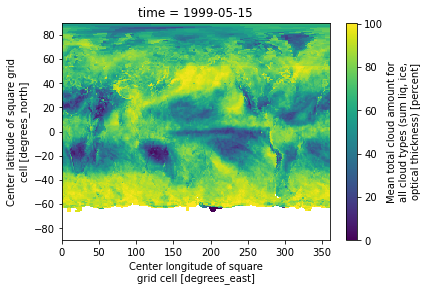

In [46]:
cltisccp.sel(time=slice('1998-07-01',None),method='nearest').squeeze().plot.pcolormesh()

<xarray.DataArray 'cldamt_types' (lat: 180, lon: 360)>
array([[      nan,       nan,       nan, ...,       nan,       nan,
              nan],
       [      nan,       nan,       nan, ...,       nan,       nan,
              nan],
       [      nan,       nan,       nan, ...,       nan,       nan,
              nan],
       ...,
       [50.299995, 50.299995, 50.299995, ..., 55.199997, 55.199997,
        55.199997],
       [55.69999 , 55.69999 , 55.69999 , ..., 55.19999 , 55.19999 ,
        55.19999 ],
       [53.79999 , 53.79999 , 53.79999 , ..., 52.899998, 52.899998,
        52.899998]], dtype=float32)
Coordinates:
  * lon      (lon) float32 0.5 1.5 2.5 3.5 4.5 ... 355.5 356.5 357.5 358.5 359.5
  * lat      (lat) float32 -89.5 -88.5 -87.5 -86.5 -85.5 ... 86.5 87.5 88.5 89.5
    time     datetime64[ns] 1998-06-15
Attributes:
    long_name:      Mean cloud amount for cloud types
    units:          percent
    valid_min:      -500
    valid_max:      500
    description:    Cloud detected by either IR or VIS threshold, type determ...
    standard_name:  isccp_cloud_area_fraction
    cell_methods:   area: mean time: mean within days time: mean over days

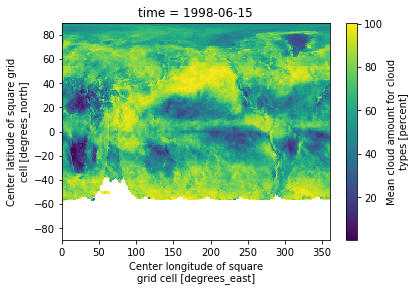

In [48]:
# question: Does the geostationary artifact in Indian Ocean go away in time?

cltisccp.sel(time='1998-06-01',method='nearest').squeeze().plot.pcolormesh()
# answer: yes ; gone in 2000-2009
# present in 1990-2000 mean, 1995-2000, 
cltisccp.sel(time='1998-06-01',method='nearest')
# LAST MONTH WITH ARTIFACT IS 1998-06

/Users/brianpm/miniconda3/envs/w/lib/python3.8/site-packages/xarray/core/nanops.py:140: RuntimeWarning: Mean of empty slice
  return np.nanmean(a, axis=axis, dtype=dtype)


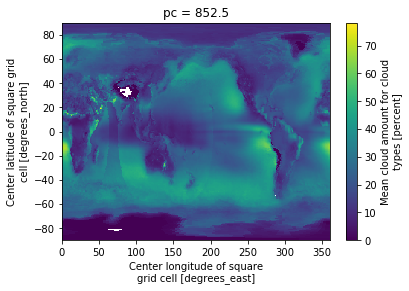

In [58]:
# question: Does the geostationary artifact in Indian Ocean appear in low-level clouds?

cllisccp.sel(time=slice(None,'1998-06-01')).mean(dim='time').squeeze().plot.pcolormesh()
# answer: yes 

/Users/brianpm/miniconda3/envs/w/lib/python3.8/site-packages/xarray/core/nanops.py:140: RuntimeWarning: Mean of empty slice
  return np.nanmean(a, axis=axis, dtype=dtype)


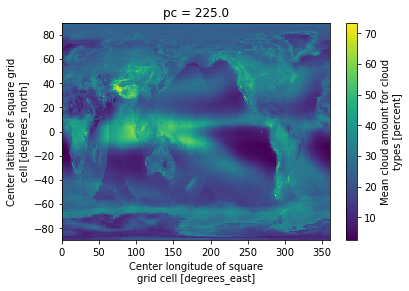

In [60]:
# question: Does the geostationary artifact in Indian Ocean appear in high-level clouds?

clhisccp.sel(time=slice(None,'1998-06-01')).mean(dim='time').squeeze().plot.pcolormesh()
# answer: yes 

In [97]:
cltisccp['time'][-1]

<xarray.DataArray 'time' ()>
array('2016-12-15T00:00:00.000000000', dtype='datetime64[ns]')
Coordinates:
    time     datetime64[ns] 2016-12-15
Attributes:
    long_name:    Time
    climatology:  climatology_bounds
    bounds:       climatology_bounds

In [50]:
# Note: polar night covered by zeros instead of missing ... check in the original data
cltisccp.sel(time='1998-06-01',lat=-70, lon=10, method='nearest').values

array(nan, dtype=float32)

In [51]:
obs_clisccp.sel(time='1998-06-01', lat=-70, lon=10, method='nearest').values

array([[nan, nan, nan],
       [nan, nan, nan],
       [nan, nan, nan]], dtype=float32)

In [52]:
obs_clisccp.sel(time='1998-06-01', lat=-70, lon=10, method='nearest').sum(dim=("tau"), min_count=1).sum(dim='pc', min_count=1).values

array(nan)